<a href="https://colab.research.google.com/github/SiracencoSerghei/DataScienceHW/blob/main/example_kaggle/les_9/improving_3_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.metrics import accuracy_score


In [2]:

# Налаштування параметрів
num_classes = 10
num_features = 784
learning_rate = 0.001
training_steps = 3000
batch_size = 256
display_step = 100

n_hidden_1 = 128
n_hidden_2 = 256

# Завантажуємо набір даних MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.

# Формуємо датасет для навчання
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

# Клас повнозв'язного шару
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, activation=None):
        super().__init__()
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.activation = activation

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return self.activation(y) if self.activation else y

# Клас нейромережі
class NN(tf.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = DenseLayer(num_features, n_hidden_1, activation=tf.nn.sigmoid)
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, activation=tf.nn.sigmoid)
        self.out_layer = DenseLayer(n_hidden_2, num_classes, activation=tf.nn.softmax)

    def __call__(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.out_layer(x)

# Функція втрат
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

# Функція точності
def accuracy(y_pred, y_true):
    return accuracy_score(y_true, np.argmax(y_pred, axis=1))

# Функція навчання
def train(neural_net, input_x, output_y, optimizer):
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)
    gradients = g.gradient(loss, [neural_net.layer1.w, neural_net.layer1.b,
                                  neural_net.layer2.w, neural_net.layer2.b,
                                  neural_net.out_layer.w, neural_net.out_layer.b])
    optimizer.apply_gradients(zip(gradients, [neural_net.layer1.w, neural_net.layer1.b,
                                              neural_net.layer2.w, neural_net.layer2.b,
                                              neural_net.out_layer.w, neural_net.out_layer.b]))
    return loss

# Функція для запуску тренування з вибором методу оптимізації
def train_network(optimizer_type):
    neural_net = NN()
    loss_history = []
    accuracy_history = []

    if optimizer_type == "SGD":
        optimizer = tf.optimizers.SGD(learning_rate)
    elif optimizer_type == "BatchGD":
        optimizer = tf.optimizers.Adam(learning_rate)

    for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
        loss = train(neural_net, batch_x, batch_y, optimizer)
        if step % display_step == 0:
            pred = neural_net(batch_x)
            acc = accuracy(pred.numpy(), batch_y.numpy())
            loss_history.append(loss.numpy())
            accuracy_history.append(acc)
            print(f"{optimizer_type} - Крок {step}, Втрата: {loss.numpy():.4f}, Точність: {acc:.4f}")

    return loss_history, accuracy_history

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
# Запускаємо тренування для SGD та Batch Gradient Descent
loss_sgd, acc_sgd = train_network("SGD")
loss_batchgd, acc_batchgd = train_network("BatchGD")

SGD - Крок 100, Втрата: 13.1224, Точність: 0.1523
SGD - Крок 200, Втрата: 12.5257, Точність: 0.0977
SGD - Крок 300, Втрата: 11.1985, Точність: 0.1016
SGD - Крок 400, Втрата: 10.0896, Точність: 0.0820
SGD - Крок 500, Втрата: 9.0345, Точність: 0.1133
SGD - Крок 600, Втрата: 8.3145, Точність: 0.1055
SGD - Крок 700, Втрата: 7.7590, Точність: 0.1289
SGD - Крок 800, Втрата: 7.7504, Точність: 0.1289
SGD - Крок 900, Втрата: 7.1885, Точність: 0.1641
SGD - Крок 1000, Втрата: 7.0794, Точність: 0.1328
SGD - Крок 1100, Втрата: 6.4608, Точність: 0.1523
SGD - Крок 1200, Втрата: 6.7090, Точність: 0.1055
SGD - Крок 1300, Втрата: 6.5235, Точність: 0.1289
SGD - Крок 1400, Втрата: 6.0099, Точність: 0.1953
SGD - Крок 1500, Втрата: 5.9481, Точність: 0.1836
SGD - Крок 1600, Втрата: 6.3428, Точність: 0.1484
SGD - Крок 1700, Втрата: 5.6433, Точність: 0.2344
SGD - Крок 1800, Втрата: 6.1027, Точність: 0.1289
SGD - Крок 1900, Втрата: 5.8092, Точність: 0.1914
SGD - Крок 2000, Втрата: 5.4635, Точність: 0.2070
SGD -

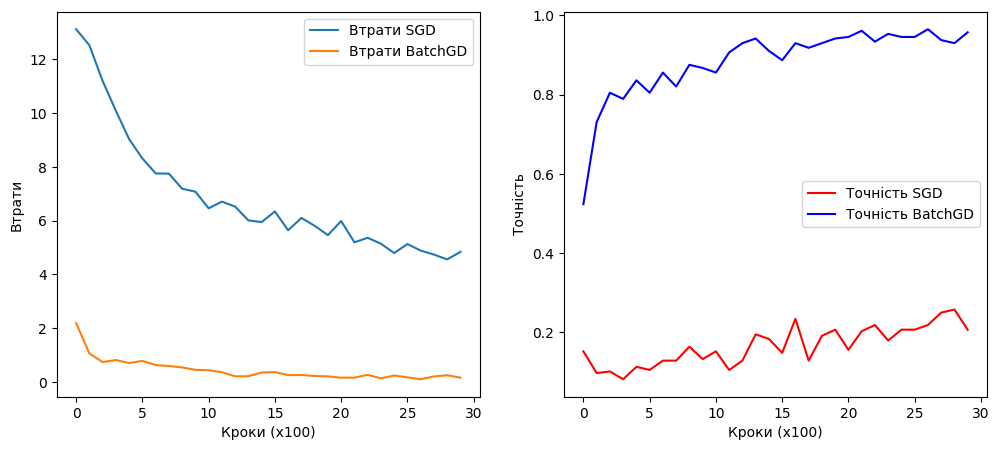

In [4]:
# Візуалізація результатів
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_sgd, label='Втрати SGD')
plt.plot(loss_batchgd, label='Втрати BatchGD')
plt.xlabel("Кроки (x100)")
plt.ylabel("Втрати")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_sgd, label='Точність SGD', color='red')
plt.plot(acc_batchgd, label='Точність BatchGD', color='blue')
plt.xlabel("Кроки (x100)")
plt.ylabel("Точність")
plt.legend()

plt.show()